# Tensorflow Recommenders:

In this notebook we peek into the possibility of using Tensorflow recommender system (tfrs) -  Retrieval models for H&M product recommendations.

Retrieval models have typically query and candidate models in which features are embedded. Affinity score is calculated by a factorized retrieval model.The retrieval task is for selecting an initial set of candidates from all possible candidates.

Tensorflow has easy to implement modules such as *tfrs.tasks.Retrieval* along with metrics such as *tfrs.metrics.FactorizedTopK* for retrieval task.

Tensorflow *ScaNN* library can be used to retrieve the best candidates for a given query. In our case we can get the 12 recommendations required using this library.

In [1]:
!pip install tensorflow-recommenders
!pip install scann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 999.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 64.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 34.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uni

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import cudf
import os
import matplotlib.pyplot as plt
import cv2

from pathlib import Path
from typing import Dict, Text

# The Dataset

In [3]:
data_dir = Path('../input/h-and-m-personalized-fashion-recommendations')
train0 = pd.read_csv(data_dir/'transactions_train.csv')
train0 = train0[train0['t_dat'] >='2020-09-01']

# add 0 in article_id column (string)
train0['article_id'] = train0['article_id'].astype(str)
train0['article_id'] = train0['article_id'].apply(lambda x: x.zfill(10))
train0.head()

,t_dat,customer_id,article_id,price,sales_channel_id
30990055,2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0777148006,0.013542,1
30990056,2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0835801001,0.018627,1
30990057,2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0923134005,0.012695,1
30990058,2020-09-01,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0865929003,0.016932,1
30990059,2020-09-01,0005ed68483efa39644c45185550a82dd09acb07622acb...,0863646004,0.033881,1


In [4]:
customer_df = pd.read_csv(data_dir/'customers.csv')
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [ ]:
article_df = pd.read_csv(data_dir/'articles.csv')

article_df['article_id'] = article_df['article_id'].astype(str)
article_df['article_id'] = article_df['article_id'].apply(lambda x: x.zfill(10))
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


We select only two features for training. Also generate data for embedding in both query and candidate models.


In [6]:
#get data for embedding and task

unique_customer_ids = customer_df.customer_id.unique()
unique_article_ids = article_df.article_id.unique()

article_ds = tf.data.Dataset.from_tensor_slices(dict(article_df[['article_id']]))
articles = article_ds.map(lambda x: x['article_id'])


# Query, Candidate and H&M model 

In [7]:
embedding_dimension = 64

# Query Model
customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_customer_ids, mask_token=None),  
  tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension)
])

In [8]:
# Candidate Model
article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_article_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension)
])

In [9]:
# Retrieval Model

class HandMModel(tfrs.Model):
    
    def __init__(self, customer_model, article_model):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model),            
            ),
        )        

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
    
        customer_embeddings = self.customer_model(features["customer_id"])    
        article_embeddings = self.article_model(features["article_id"])

        # The task computes the loss and the metrics.
        return self.task(customer_embeddings, article_embeddings,compute_metrics=not training)

# Train & Validate

In [10]:
model = HandMModel(customer_model, article_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [11]:
train = train0[train0['t_dat']<='2020-09-15']
test = train0[train0['t_dat'] >='2020-09-15']

train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000).batch(256).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(test[['customer_id','article_id']])).batch(256).cache()

num_epochs = 5

'''

history = model.fit(
    train_ds, 
    validation_data = test_ds,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

'''


'\n\nhistory = model.fit(\n    train_ds, \n    validation_data = test_ds,\n    validation_freq=5,\n    epochs=num_epochs,\n    verbose=1)\n\n'

**A word on metrics:**

Calculation of factorized top K metric is highly time intensive. Even with the option 'compute_metrics=not training' and 
computing validation metrics only every 5 epochs, it still takes a lot of time. You can check this by running above model. Another option 
may be by reducing the number of retrievals from standard 100.(may cost accuracy?)

self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
        candidates=articles.batch(128).map(self.article_model),
        k = (any value less than 100)
        )

# Retrieve & Submit

In [12]:
# train without validation

train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000).batch(256).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(test[['customer_id','article_id']])).batch(256).cache()

num_epochs = 5

history = model.fit(
    train_ds,    
    epochs=num_epochs,
    verbose=1)

Epoch 1/10
2180/2180 [==============================] - 10s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1418.6173 - regularization_loss: 0.0000e+00 - total_loss: 1418.6173
Epoch 2/10
2180/2180 [==============================] - 8s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1416.1484 - regularization_loss: 0.0000e+00 - total_loss: 1416.1484
Epoch 3/10
2180/2180 [==============================] - 8s 4ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+

In [13]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.customer_model, k = 12 )
scann_index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(100), articles.batch(100).map(model.article_model)))
)

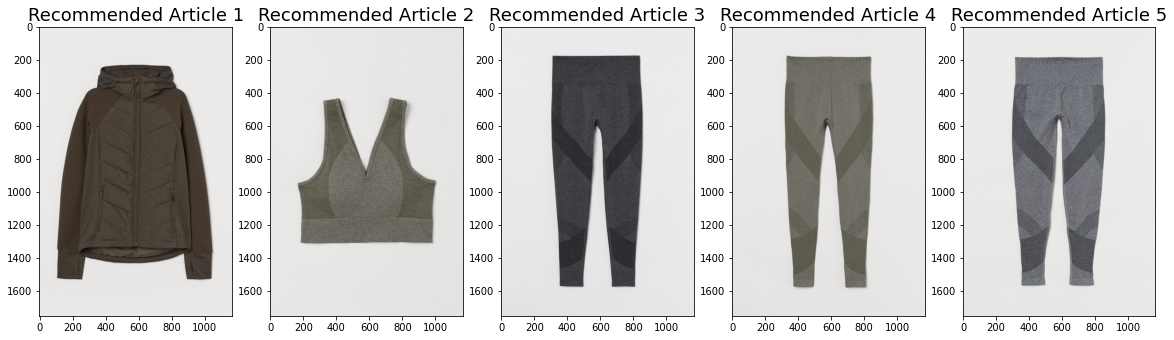

In [ ]:
BASE = '../input/h-and-m-personalized-fashion-recommendations/images/'

chosen_consumer_id = "000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318"

_, recommended_articles = scann_index(np.array([chosen_consumer_id]))

recommended_article_ids = [id.decode('utf-8') for id in recommended_articles[0, :5].numpy()]

names = [BASE + id[:3] + '/' + id + '.jpg' for id in recommended_article_ids]

if all(os.path.exists(name) for name in names):
    plt.figure(figsize=(20,10))
    for i, name in enumerate(names):
        img = cv2.imread(name)[:,:,::-1]
        plt.subplot(1,5,i+1)
        plt.title('Recommended Article ' + str(i+1),size=18)
        plt.imshow(img)
    plt.show()



Getting recommendations for consumer ID: ff4b910fe2b3dd5484c16b28ce41ffadfb56825baf33511370d5535b23424f33


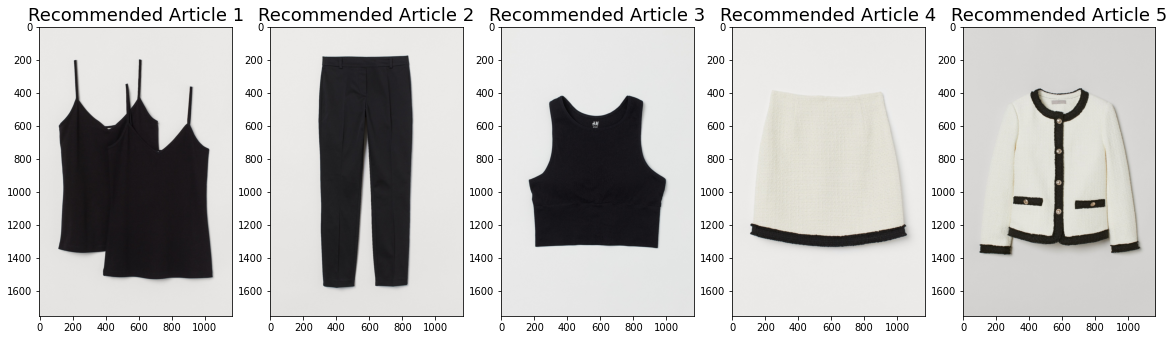


Getting recommendations for consumer ID: 3e1824f65b15d21df081df2293dfdb414101d3f23fb0a59a146a3405850b31cb


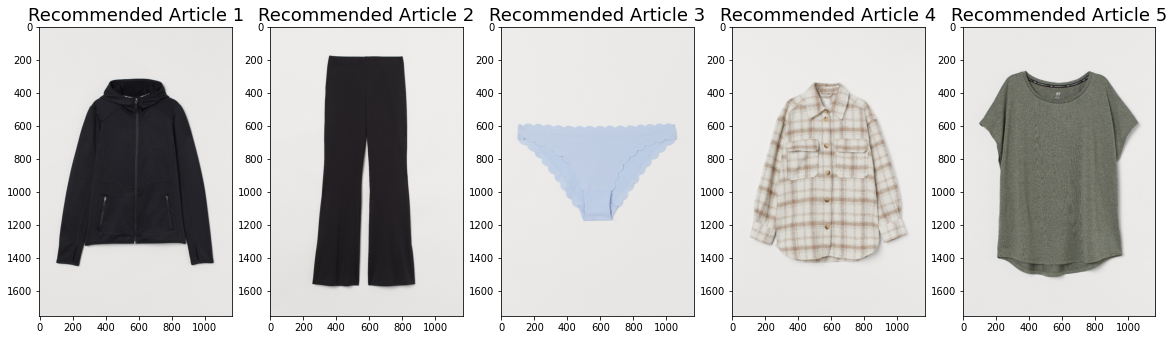

In [ ]:
chosen_consumer_ids = np.random.choice(unique_customer_ids, size=2, replace=False)

for chosen_consumer_id in chosen_consumer_ids:
    print(f"\nGetting recommendations for consumer ID: {chosen_consumer_id}")
    _, recommended_articles = scann_index(np.array([chosen_consumer_id]))

    recommended_article_ids = [id.decode('utf-8') for id in recommended_articles[0, :5].numpy()]

    names = [BASE + id[:3] + '/' + id + '.jpg' for id in recommended_article_ids]

    if all(os.path.exists(name) for name in names):
        plt.figure(figsize=(20,10))
        for i, name in enumerate(names):
            img = cv2.imread(name)[:,:,::-1]
            plt.subplot(1,5,i+1)
            plt.title('Recommended Article ' + str(i+1),size=18)
            plt.imshow(img)
        plt.show()
    else:
        for name in names:
            if not os.path.exists(name):
                print(f"The image does not exist: {name}")


Getting recommendations for article ID: 0685687003
Raw recommendations: tf.Tensor(
[[b'0715624001' b'0685814001' b'0895837002' b'0685814022' b'0915526001'
  b'0845790002' b'0715624052' b'0685814062' b'0857163003' b'0610776105'
  b'0685813040' b'0685816002']], shape=(1, 12), dtype=string)
Recommended article IDs: ['0685687003', '0715624001', '0685814001', '0895837002']
../input/h-and-m-personalized-fashion-recommendations/images/068/0685687003.jpg
../input/h-and-m-personalized-fashion-recommendations/images/071/0715624001.jpg
../input/h-and-m-personalized-fashion-recommendations/images/068/0685814001.jpg
../input/h-and-m-personalized-fashion-recommendations/images/089/0895837002.jpg


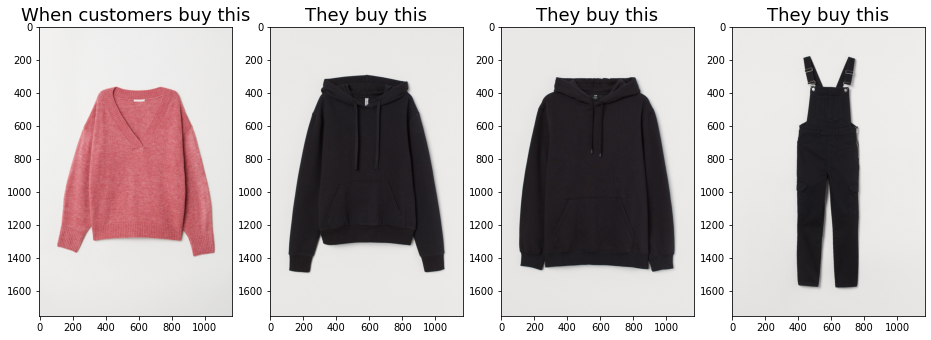

In [ ]:
chosen_article_id = "0685687003"

print(f"Getting recommendations for article ID: {chosen_article_id}")
_, recommended_articles = scann_index(np.array([chosen_article_id]))

print("Raw recommendations:", recommended_articles)

recommended_article_ids = [chosen_article_id] + [id.decode('utf-8') for id in recommended_articles[0, :3].numpy()]  

print("Recommended article IDs:", recommended_article_ids)

names = [BASE + id[:3] + '/' + id + '.jpg' for id in recommended_article_ids]

for name in names:
    print(name)

if all(os.path.exists(name) for name in names):
    plt.figure(figsize=(20,10))
    for i, name in enumerate(names):
        img = cv2.imread(name)[:,:,::-1]
        plt.subplot(1,5,i+1)
        if i == 0:
            plt.title('When customers buy this',size=18)
        else:
            plt.title('They buy this',size=18)
        plt.imshow(img)
    plt.show()
else:
    for name in names:
        if not os.path.exists(name):
            print(f"The image does not exist: {name}")



Getting recommendations for article ID: 0860623005


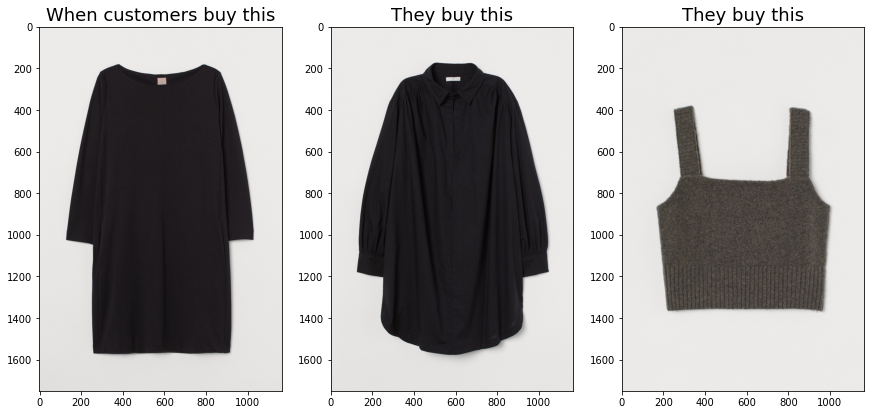

Embedding for article ID 0860623005: [[ 0.04739488  0.02905196  0.04685402 -0.00901142  0.02501854  0.03697205
   0.03968481 -0.02616667  0.00978294  0.05755546 -0.05068405 -0.05094012
   0.02492478  0.05408087 -0.0515668   0.00855734 -0.01919394  0.04300242
  -0.02207981 -0.02093333 -0.03118691 -0.01643796  0.04486329  0.0012704
  -0.01589901 -0.031962    0.02525623 -0.0393489  -0.03446718 -0.02340906
   0.01690823  0.03415873  0.03544253  0.02615535  0.00895488  0.05941214
  -0.0069278   0.00670892 -0.03755032 -0.01320703 -0.02877612  0.05444654
   0.03110007  0.05772038 -0.04116365  0.03106792 -0.02916521  0.02781448
  -0.03344865 -0.04802317 -0.05894514  0.03792807  0.05950225 -0.00942664
  -0.01826645  0.0311993   0.00371432 -0.00669258  0.00572749 -0.01818645
   0.01336841 -0.03651595 -0.02275957 -0.05282939 -0.00025117  0.00030208
  -0.03853424 -0.01009301 -0.04599247 -0.01272172 -0.01787279 -0.02985867
   0.04187469 -0.04130298 -0.00885687 -0.00335508 -0.04462335 -0.00445652
  

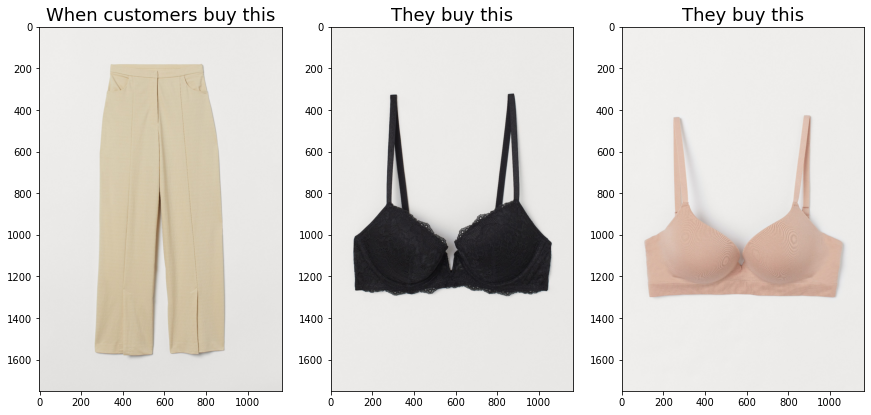

Embedding for article ID 0928040001: [[-0.0219088   0.13600822 -0.08451708  0.18095896  0.0356763   0.11765001
   0.09454428 -0.01637137  0.09298074  0.12081428  0.01831444 -0.09867838
  -0.05680528 -0.14244007  0.2313985  -0.01139308 -0.1372339   0.14441901
  -0.13412242 -0.06877667  0.00917163  0.22516702 -0.11604606 -0.01250849
  -0.12505381  0.118136    0.13535394 -0.01791177 -0.10988925 -0.05994193
   0.02152422  0.09251542 -0.10765526 -0.22982998  0.17152944  0.00847852
  -0.04158079 -0.18668307  0.22373715 -0.2150846   0.05744588  0.11762851
   0.05522893 -0.05240425  0.04351565  0.07843288  0.08688456 -0.01863832
   0.13035749 -0.02819086  0.10445643 -0.12287281  0.13969912  0.14860822
  -0.03856432  0.06907555 -0.01050304  0.12134917 -0.08186091 -0.06554647
   0.0440597   0.02309112 -0.02095828 -0.04950729 -0.24084331 -0.13667351
   0.15624386  0.1329664   0.07477216  0.12328531 -0.08908585 -0.17157342
  -0.0037582   0.20279606 -0.13988669  0.08143745  0.03901169  0.02915289
 

In [ ]:
import os
import numpy as np
import tensorflow as tf

def exists(path):
    return os.path.isfile(path)

vc = train0.article_id.value_counts()

pairs = {}

chosen_article_ids = np.random.choice(vc.index.values, size=2, replace=False)

for chosen_article_id in chosen_article_ids:
    print(f"\nGetting recommendations for article ID: {chosen_article_id}")

    USERS = train0.loc[train0.article_id==chosen_article_id,'customer_id'].unique()

    recommendations = []

    for user in USERS:
        _, articles_recommended = scann_index(tf.constant([user]))

        recommendations.extend(articles_recommended.numpy()[0])

    vc2 = pd.Series(recommendations).value_counts()

    pairs[chosen_article_id] = [vc2.index[0], vc2.index[1], vc2.index[2]]

    names = [BASE + id.decode("utf-8")[:3] + '/' + id.decode("utf-8") + '.jpg' for id in pairs[chosen_article_id]]

    plt.figure(figsize=(20,10))
    for i, name in enumerate(names):
        if exists(name):
            img = cv2.imread(name)[:,:,::-1]
            plt.subplot(1,4,i+1)
            if i == 0:
                plt.title('When customers buy this',size=18)
            else:
                plt.title('They buy this',size=18)
            plt.imshow(img)
    plt.show()

    article_embedding = model.article_model(np.array([chosen_article_id]))
    print(f"Embedding for article ID {chosen_article_id}: {article_embedding.numpy()}")


In [ ]:
embedding1 = model.article_model(np.array([chosen_article_ids[0]]))
embedding2 = model.article_model(np.array([chosen_article_ids[1]]))
cosine_similarity = dot(embedding1.numpy(), tf.transpose(embedding2).numpy())/(norm(embedding1.numpy())*norm(embedding2.numpy()))

print("\nCosine similarity between the two embeddings:", cosine_similarity)

NameError: name 'dot' is not defined